In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from catboost import CatBoostClassifier
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [ ]:
def resumetable(df):
  print(f"Dataset Shape: {df.shape}")
  summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
  summary = summary.reset_index()
  summary['Name'] = summary['index']
  summary = summary[['Name','dtypes']]
  summary['Missing'] = df.isnull().sum().values
  summary['uniques'] = df.nunique().values
  summary['First Value']  = df.loc[0].values
  summary['Second Value'] = df.loc[1].values
  return summary

In [ ]:
!ls

Balanced_Smote.xlsx  catboost_info  sample_data


In [ ]:
file_loc = 'Balanced_Smote.xlsx'

In [ ]:
df = pd.read_excel(file_loc)

In [ ]:
df.head()


,T,WS,H,P,TS
0,34,17,39,1008,0
1,34,15,39,1007,0
2,35,11,34,1007,0
3,36,11,35,1007,0
4,37,9,33,1007,0


In [ ]:
print('Total number of rows in dataset ={}'.format(df.shape[0]))
print('Total number of columns in dataset ={}'.format(df.shape[1]))

Total number of rows in dataset =1076
Total number of columns in dataset =5


In [ ]:
target_col = 'TS'
X = df.loc[: ,df.columns !=target_col]
y = df.loc[:, target_col]

In [ ]:
print(X.head())

    T  WS   H     P
0  34  17  39  1008
1  34  15  39  1007
2  35  11  34  1007
3  36  11  35  1007
4  37   9  33  1007


In [ ]:
print(y.head())

0    0
1    0
2    0
3    0
4    0
Name: TS, dtype: int64


In [ ]:
categorical_features = np.where(df[X.columns].dtypes!=float)[0]
print(categorical_features)

[0 1 2 3]


In [ ]:
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=1)

In [ ]:
X_train.head()

,T,WS,H,P
293,34,19,56,1006
1026,30,15,66,1002
744,33,6,53,1002
1003,25,11,74,1005
74,35,13,47,1006


In [ ]:
params = {'iterations':5000,
        'learning_rate':0.01,
        'cat_features':categorical_features,
        'depth':3,
        'eval_metric':'AUC',
        'verbose':200,
        'od_type':"Iter", # overfit detector
        'od_wait':500, # most recent best iteration to wait before stopping
        'random_seed': 1
          }

In [ ]:
model_cb = CatBoostClassifier(**params)

In [ ]:
model_cb.fit(X_train,y_train,plot=True,eval_set = (X_test,y_test))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7858270	best: 0.7858270 (0)	total: 3.01ms	remaining: 15s
200:	test: 0.8476641	best: 0.8476641 (200)	total: 422ms	remaining: 10.1s
400:	test: 0.8591225	best: 0.8591225 (400)	total: 1.08s	remaining: 12.4s
600:	test: 0.8631944	best: 0.8632576 (597)	total: 1.52s	remaining: 11.1s
800:	test: 0.8662879	best: 0.8664141 (796)	total: 1.99s	remaining: 10.4s
1000:	test: 0.8682449	best: 0.8682449 (1000)	total: 2.44s	remaining: 9.74s
1200:	test: 0.8693813	best: 0.8695391 (1172)	total: 2.88s	remaining: 9.11s
1400:	test: 0.8688131	best: 0.8697601 (1319)	total: 3.5s	remaining: 8.98s
1600:	test: 0.8690657	best: 0.8697601 (1319)	total: 3.9s	remaining: 8.28s
1800:	test: 0.8695707	best: 0.8700758 (1732)	total: 4.41s	remaining: 7.84s
2000:	test: 0.8693182	best: 0.8700758 (1732)	total: 4.83s	remaining: 7.24s
2200:	test: 0.8685922	best: 0.8700758 (1732)	total: 5.38s	remaining: 6.84s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.8700757576
bestIteration = 1732

Shrink model to

In [ ]:
y_pred = model_cb.predict(X_test)

In [ ]:
f1_score(y_test,y_pred)

0.807909604519774

In [ ]:
accuracy_score(y_test,y_pred)

0.8089887640449438

In [ ]:
confusion_matrix(y_test,y_pred)

array([[145,  31],
       [ 37, 143]])

In [ ]:
matrix=classification_report(y_test,y_pred)
print('classification report : \n',matrix)

classification report : 
               precision    recall  f1-score   support

           0       0.80      0.82      0.81       176
           1       0.82      0.79      0.81       180

    accuracy                           0.81       356
   macro avg       0.81      0.81      0.81       356
weighted avg       0.81      0.81      0.81       356



In [ ]:
	
print('Precision: %f' % precision_score(y_test, y_pred))

print('Recall: %f' % recall_score(y_test, y_pred))

Precision: 0.821839
Recall: 0.794444


In [ ]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from catboost import CatBoostClassifier, Pool
shap_values = model_cb.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_features) ,
                                               type="ShapValues")
 
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[0,:], X_test.iloc[0,:])

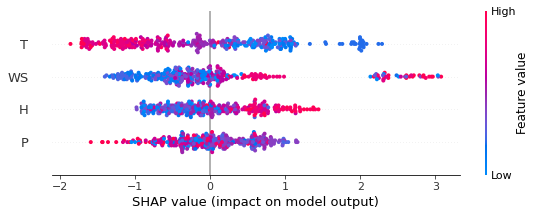

In [ ]:
shap.summary_plot(shap_values, X_test)

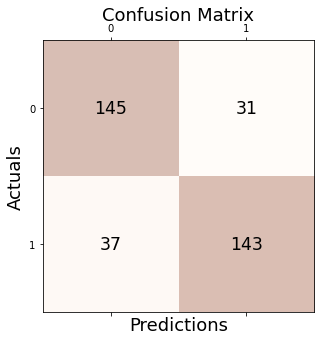

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
#
# Standardize the data set
#
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
#
# Fit the SVC model
#
svc = SVC(kernel='linear', C=10.0, random_state=1)
svc.fit(X_train, y_train)

# Calculate the confusion matrix
#
conf_matrix = confusion_matrix(y_test,y_pred)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()